In [1]:
%pylab inline
import gc
import numpy as np
import astropy.io.fits as pyfits

import fpfsBase

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd wrkDir/FPFS2/sim

/lustre/work/xiangchong.li/work/FPFS2/sim


In [15]:
def estimate(Clist=np.array([25,50,100,200,400,800,1600.]),noiRev=True):
    nsim=800
    vdir='outcome-var7em3'
    nic=len(Clist)
    gest=np.zeros((nsim,nic))
    slow=0.0
    dss=0.01
    for ifield in range(nsim):
        igroup=ifield//250
        fname1=os.path.join(vdir,'fpfs-rcut16-psf60-%d/src%04d-g1-2222.fits' %(igroup,ifield))
        moments1=pyfits.getdata(fname1)
        fname2=os.path.join(vdir,'fpfs-rcut16-psf60-%d/src%04d-g1-0000.fits' %(igroup,ifield))
        moments2=pyfits.getdata(fname2)

        for ic in range(nic):
            C=Clist[ic]
            elli1=fpfsBase.fpfsM2E(moments1,C,rev=noiRev)
            mask=elli1['fpfs_s0']>slow
            elli1=elli1[mask]
            mask2=elli1['fpfs_s0']<slow+dss
            RS=0.#-np.sqrt(2.)*np.sum((1-elli1[mask2]['fpfs_s0'])*elli1[mask2]['fpfs_e1']**2./dss)
            g1p=np.sum(elli1['fpfs_e1'])/(np.sum(elli1['fpfs_RE'])+RS)

            elli2=fpfsBase.fpfsM2E(moments2,C,rev=noiRev)
            mask=elli2['fpfs_s0']>slow
            elli2=elli2[mask]
            mask2=elli2['fpfs_s0']<slow+dss
            RS=0.#-np.sqrt(2.)*np.sum((1-elli2[mask2]['fpfs_s0'])*elli2[mask2]['fpfs_e1']**2./dss)
            g1m=np.sum(elli2['fpfs_e1'])/(np.sum(elli2['fpfs_RE'])+RS)

            gest[ifield,ic]=g1m-g1p
            del elli1,elli2,mask,mask2
            gc.collect
        del moments1,moments2
        gc.collect
    return np.average(gest,axis=0)/0.04-1,np.std(gest,axis=0)/0.04/np.sqrt(nsim)

In [16]:
Clist=np.array([25,50,100,200,400,800,1600.,3200])
mT,merrT=estimate(Clist,True)
mF,merrF=estimate(Clist,False)

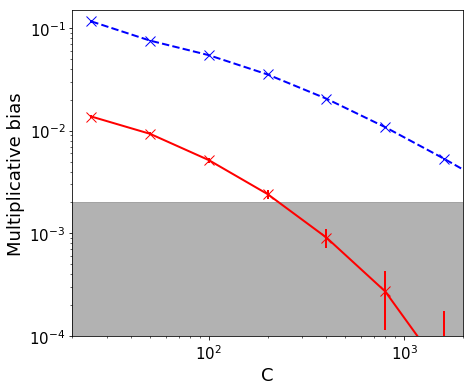

In [30]:
pltDir='plot/noiseBias/'
plt.close()
fig=plt.figure(figsize=(7,6))
ax=fig.add_subplot(1,1,1)
msk=mT<0.
ax.errorbar(Clist[msk],np.abs(mT)[msk],merrT[msk],fmt='x',c='red',markersize=10)
ax.errorbar(Clist[~msk],np.abs(mT)[~msk],merrT[~msk],fmt='o',c='red',markersize=10)
ax.errorbar(Clist,mT,merrT,fmt='-',c='red')
ax.errorbar(Clist,-mT,merrT,fmt='-',c='red')

msk=mF<0.
ax.errorbar(Clist[msk],np.abs(mF)[msk],merrF[msk],fmt='x',c='blue',markersize=10)
ax.errorbar(Clist[~msk],np.abs(mF)[~msk],merrF[~msk],fmt='o',c='blue',markersize=10)
ax.errorbar(Clist,mF,merrF,fmt='--',c='blue')
ax.errorbar(Clist,-mF,merrF,fmt='--',c='blue')
ax.set_xlabel('C')
ax.set_ylabel(r'Multiplicative bias')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(2e1,2e3)
ax.set_ylim(1e-4,1.5e-1)
ax.fill_between(np.linspace(10,2000,100),np.zeros(100),2e-3*np.ones(100),color='gray',alpha=0.6)
fig.savefig(os.path.join(pltDir,'noiseBias.png'))
fig.savefig(os.path.join(pltDir,'noiseBias.pdf'))